# Imports


In [282]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import math
import time
from fake_useragent import UserAgent
import validators
import matplotlib.pyplot as plt
import mplcursors
import plotly.express as px

In [247]:
%run library.ipynb

# Load in Existing Dataset:

In [125]:
scraped_data = pd.read_csv("scraped_data_old.csv")
scraped_data.set_index(list(scraped_data.columns)[0], inplace=True)

In [3]:
# just scrape wild turkey
# adjusted by mean price increase from last auction
# basket of bourbons, scotches, japanese - look for differences in pricing


# OG Scraping

In [38]:
lots_dict = {}
categories = ['Distillery', 'Age', 'Vintage', 'Region', 'Bottler', 'Cask Type', 'Bottled Strength', 'Bottle Size',
             'Distillery Status']
ua = UserAgent()
date_format = "%d.%m.%y"
per_page = 40


In [81]:
date_format = "%y.%d.%m"

In [39]:
def og_scraper():
    '''Scrapes data from Whiskey Auctioneer and saves to dictionary'''
    
    # more_new_data = True

    # URL of the first page of results
    url_stem = "https://whiskyauctioneer.com/auction-search"
    
    url = True
    
    try:
        live_url = "https://whiskyauctioneer.com/current-auction"
        page = requests.get(live_url, headers={'user-agent': ua.random})
        soup = BeautifulSoup(page.content, "html.parser")
        start_page = math.floor(int(re.findall(r'\d+', soup.find("p", class_ = "left").text)[0]) / per_page)-1
        i = start_page
        
    except:
        #i = 0
        i = 369
    
    # Loop through remaining pages until you get to where there aren't any more
    while url:
        
        if i == 0:
            url = url_stem
        else:
            url = url_stem + f'?page={i}'

        page = requests.get(url, headers={'user-agent': ua.random})
        soup = BeautifulSoup(page.content, "html.parser")
        
        result_1 = soup.find("div", class_ ="views-row views-row-1 views-row-odd views-row-first producthomepage")
        result = result_1
        
        # Now we need to iterate through the lots on the page
        while result != None:

            lot_dict = {}
            
            lot_num = int(re.findall(r'\d+', result.find("span", class_ = "lotnumber label-lot").text)[0])
            if lot_num in list(scraped_data.index):
                
                more_new_data = False
                result = result.nextSibling
                continue
            
            # Skip this iteration if the lot is part of a current auction:
            if "Bid Now" in result.text:
                result = result.nextSibling
                continue
                 
            lot_dict["name"] = result.find("a")["_title"]
            lot_dict["price"] = int(''.join(re.findall(r'\d+', result.find("div", class_ = "lotwin cru").text)))
            if "Reserve not met" in result.find("div", class_ = "lotwin cru").text:
                lot_dict['reserve_met'] = 0
            elif "Reserve has been met" in result.find("div", class_ = "lotwin cru").text:
                lot_dict['reserve_met'] = 1
            lot_dict['end_date'] = datetime.strptime(result.find("div", 
                                class_ = "enddatein").text.split(':')[1].strip(), date_format).date()
            lot_num = int(re.findall(r'\d+', result.find("span", class_ = "lotnumber label-lot").text)[0])
               
            # Get lot site
            lot_url = result.find("a", href=True)['href']
           
            
            lot_page = requests.get(lot_url, headers={'user-agent': ua.random})
            lot_soup = BeautifulSoup(lot_page.content, "html.parser")
            
            
            try:
                child = lot_soup.find("div", class_ = "whiskyproduct").findChild()
            except:
                print(lot_url)
                result = result.nextSibling
                continue
            # Iterate through children to get all info
            while child:
                
                for val in categories:
                    if val in child.text:
                        cat = val
                        
                value = str(child.text).replace("\xa0", '').split(':')[1]
                
                lot_dict[cat] = value
                
                child = child.nextSibling
                
            prod_details = lot_soup.find("div", {"class": "field-item even", 
                                                 "property": "content:encoded"}).text.replace("\xa0", '')
            
            lot_dict['details'] = prod_details
                
            lots_dict[lot_num] = lot_dict
            
            # This iterates the loop to the next lot
            result = result.nextSibling
            
            time.sleep(3)
        
        print(f"Done page {i}")
        i += 1
        time.sleep(3)
         
        
    return lots_dict
        

In [40]:
#og_scraper()

In [36]:
scraped_data_cur = pd.DataFrame.from_dict(lots_dict, orient = "index")
scraped_data = pd.concat([scraped_data, scraped_data_cur])
# REMEMBER TO RESET START NUMBER AND CLEAR LOTS DICT

In [37]:
scraped_data.to_csv("scraped_data.csv")

# Iterative Scraping

In [281]:
def scraper():
    '''Scrapes data from Whiskey Auctioneer and saves to dictionary'''
    
    more_new_data = True

    # URL of the first page of results
    url_stem = "https://whiskyauctioneer.com/auction-search"
    
    url = True
    
    live_url = "https://whiskyauctioneer.com/current-auction"
    page = requests.get(live_url, headers=headers)
    soup = BeautifulSoup(page.content, "html.parser")
    start_page = math.floor(int(re.findall(r'\d+', soup.find("p", class_ = "left").text)[0]) / per_page)-1
    
    i = start_page
    #i = 209
    
    # Loop through remaining pages until you get to where there aren't any more
    while url and more_new_data:
        print(i)
        
        if i == 0:
            url = url_stem
        else:
            url = url_stem + f'?page={i}'

        page = requests.get(url, headers=headers)
        soup = BeautifulSoup(page.content, "html.parser")
        
        result_1 = soup.find("div", class_ ="views-row views-row-1 views-row-odd views-row-first producthomepage")
        result = result_1
        # Now we need to iterate through the lots on the page
        while result and more_new_data:
            lot_dict = {}
            
            lot_num = int(re.findall(r'\d+', result.find("span", class_ = "lotnumber label-lot").text)[0])
            if lot_num in list(scraped_data.index):
                more_new_data = False
            
            # Skip this iteration if the lot is part of a current auction:
            if "Bid Now" in result.text:
                result = result.nextSibling
                continue
                 
            lot_dict["name"] = result.find("a")["_title"]
            lot_dict["price"] = int(''.join(re.findall(r'\d+', result.find("div", class_ = "lotwin cru").text)))
            lot_dict['reserve_met'] = 1 if "Reserve not met" in result.find("div", class_ = "lotwin cru").text else 0
            lot_dict['end_date'] = datetime.strptime(result.find("div", 
                                class_ = "enddatein").text.split(':')[1].strip(), date_format).date()
            lot_num = int(re.findall(r'\d+', result.find("span", class_ = "lotnumber label-lot").text)[0])
               
            # Get lot site
            lot_url = result.find("a", href=True)['href']
            
            lot_page = requests.get(lot_url, headers=headers)
            lot_soup = BeautifulSoup(lot_page.content, "html.parser")
            
            child = lot_soup.find("div", class_ = "whiskyproduct").findChild()
            # Iterate through children to get all info
            while child:
                
                for val in categories:
                    if val in child.text:
                        cat = val
                        
                value = str(child.text).replace("\xa0", '').split(':')[1]
                
                lot_dict[cat] = value
                
                child = child.nextSibling
                
            prod_details = lot_soup.find("div", {"class": "field-item even", 
                                                 "property": "content:encoded"}).text.replace("\xa0", '')
            
            lot_dict['details'] = prod_details
                
            lots_dict[lot_num] = lot_dict
            
            # This iterates the loop to the next lot
            result = result.nextSibling
        
        i += 1
        time.sleep(3)
         
        
    return lots_dict
        

In [284]:
#scraper()

In [277]:
scraped_data = pd.DataFrame.from_dict(lots_dict, orient = "index")
scraped_data.to_csv("scraped_data.csv")

# Data Cleaning

In [248]:
scraped_data_clean = scraped_data.copy()

scraped_data_clean['end_date'] = pd.to_datetime(scraped_data['end_date'], format='%Y-%d-%m')

scraped_data_clean['Age'] = scraped_data['Age'].apply(clean_age)

scraped_data_clean['name'] = [i.lower() for i in scraped_data['name']]

scraped_data_clean.Distillery = scraped_data.Distillery.apply(try_lower)

scraped_data_clean.Region = scraped_data.Region.apply(try_lower)

scraped_data_clean.Bottler = scraped_data.Bottler.apply(try_lower)

scraped_data_clean['Bottled Strength'] = scraped_data['Bottled Strength'].apply(fix_pct)

scraped_data_clean['Bottle Size'] = scraped_data['Bottle Size'].apply(fix_size)

scraped_data_clean['Distillery Status'] = scraped_data['Distillery Status'].apply(try_lower)

scraped_data_clean['Vintage'] = scraped_data['Vintage'].apply(to_number)

scraped_data_clean['Cask Type'] = scraped_data['Cask Type'].apply(try_lower)


# Output

In [249]:
scraped_data_clean.head()

,name,price,end_date,Distillery,Age,Region,Bottler,Bottled Strength,Bottle Size,Distillery Status,details,Vintage,Cask Type,reserve_met
Unnamed: 0,,,,,,,,,,,,,,
6182043,caol ila 25 year old,160,2023-04-10,caol ila,25.0,islay,official,43.0,70.0,operational,Caol Ila 25 Year OldCaol Ila distillery was bu...,NaN,NaN,NaN
6182044,midleton very rare 2022 edition,210,2023-04-10,midleton,NaN,ireland,official,40.0,70.0,operational,Midleton Very Rare 2022 EditionThe formation o...,NaN,bourbon casks,NaN
6182045,yuza first edition 2022,115,2023-04-10,yuza,NaN,japan,official,61.0,70.0,operational,Yuza First Edition 2022This is the first relea...,NaN,ex-bourbon,NaN
5119084,port ellen 1981 moon import / the sails in the...,1588,2023-04-10,port ellen,NaN,islay,moon import,46.0,70.0,closed,Port Ellen 1981 Moon Import / The Sails in the...,1981.0,2 x hogsheads,NaN
6182046,octomore 5.1,186,2023-04-10,bruichladdich,5.0,islay,official,59.5,70.0,operational,Octomore 5.1Octomore is the super-heavily peat...,NaN,NaN,NaN


In [359]:

search_df = scraped_data_clean.copy()
filters = []

while True:
    
    search_cat = input("What do you want to search by? \nOptions: \n1. Name \n2. Price \n3. Auction End Date \n4. Distillery \n5. Age \n6. Region \n7. Bottler \n8. Bottled Strength (%) \n9. Bottle Size (cl) \n10. Distillery Status \n11. Vintage \n12. Cask Type \n13. Reserve Met\nType Number or type 'Done'")
    
    if search_cat == 'Done':
        break
    
    search_cat = int(search_cat)
    
    if search_cat == 1:
        search_term = input("What are you looking for?")
        if search_term == '':
            continue
        search_df = search_df[search_df['name'].str.contains(search_term.lower(), na=False)]
        filters.append(f"Search term = {search_term}")
        
    elif search_cat == 2:
        print(f"Overall Range: {min(search_df['price']), max(search_df['price'])}")
        price_range_low = int(input("Provide lower bound:"))
        if price_range_low == '':
            price_range_low = 0
        price_range_high = int(input("Provide upper bound:"))
        if price_range_high == '':
            price_range_high = 100000000000000000000000000000
        search_df = search_df[search_df['price']<=price_range_high]
        search_df = search_df[search_df['price']>=price_range_low]
        filters.append(f"Price range = {price_range_low, price_range_high}")
        
    elif search_cat ==3:
        print(f"Auction Date Range: {min(search_df['end_date']), max(search_df['end_date'])}")
#         date_range_low = 
#         date_range_high = 
        search_df = search_df[search_df['end_date']<=date_range_high]
        search_df = search_df[search_df['end_date']>=date_range_low]
        filters.append(f"Date range = {date_range_low, date_range_high}")
        
    elif search_cat ==4:
        print(list(search_df['Distillery'].value_counts().index))
        search_term = input("What distillery are you looking for?")
        if search_term == '':
            continue
        search_df = search_df[search_df['Distillery'].str.contains(search_term.lower(), na=False)]
        filters.append(f"Distillery search term = {search_term}")
        
    elif search_cat ==5:
        print(f"Age Range: {min(search_df['Age']), max(search_df['Age'])}")
        age_range_low = float(input("Provide lower bound:"))
        age_range_high = float(input("Provide upper bound:"))
        if age_range_low == '':
            age_range_low = 0
        if age_range_high == '':
            age_range_high = 100000000000000000000000000000
        search_df = search_df[search_df['Age']<=age_range_high]
        search_df = search_df[search_df['Age']>=age_range_low]
        filters.append(f"Date range = {age_range_low, age_range_high}")
        
    elif search_cat ==6:
        print(list(search_df['Region'].value_counts().index))
        search_region = input("What region are you looking for?")
        if search_region == '':
            continue
        search_df = search_df[search_df['Region']==search_region]
        filters.append(f"Region search term = {search_region}")
        
    elif search_cat ==7:
        print(list(search_df['Bottler'].value_counts().index))
        search_bottler = input("What bottler are you looking for?")
        if search_bottler == '':
            continue
        search_df = search_df[search_df['Bottler']==search_bottler]
        filters.append(f"Bottler search term = {search_bottler}")
        
    elif search_cat ==8:
        print(f"Strength Range: {min(search_df['Bottled Strength']), max(search_df['Bottled Strength'])}")
        strength_range_low = float(input("Provide lower bound:"))
        strength_range_high = float(input("Provide upper bound:"))
        if strength_range_low == '':
            strength_range_low = 0
        if strength_range_high == '':
            strength_range_high = 100000000000000000000000000000
        search_df = search_df[search_df['Bottled Strength']<=strength_range_high]
        search_df = search_df[search_df['Bottled Strength']>=strength_range_low]
        filters.append(f"Date range = {strength_range_low, strength_range_high}")
        
    elif search_cat ==9:
        print(f"Bottle Size Range: {min(search_df['Bottle Size']), max(search_df['Bottle Size'])}")
        size_range_low = float(input("Provide lower bound:"))
        size_range_high = float(input("Provide upper bound:"))
        if size_range_low == '':
            size_range_low = 0
        if size_range_high == '':
            size_range_high = 100000000000000000000000000000
        search_df = search_df[search_df['Bottle Size']<=size_range_high]
        search_df = search_df[search_df['Bottle Size']>=size_range_low]
        filters.append(f"Date range = {size_range_low, size_range_high}")
        
    elif search_cat ==10:
        print(list(search_df['Distillery Status'].value_counts().index))
        search_status = input("What are you looking for?")
        if search_status == '':
            continue
        search_df = search_df[search_df['Distillery Status']==search_status]
        filters.append(f"Status search term = {search_status}")
        
    elif search_cat ==11:
        lst = list(search_df['Vintage'].value_counts().index)
        print(lst)
        vintage_range_low = float(input("Provide lower bound:"))
        vintage_range_high = float(input("Provide upper bound:"))
        if vintage_range_low == '':
            vintage_range_low = 0
        if vintage_range_high == '':
            vintage_range_high = 100000000000000000000000000000
        search_df = search_df[search_df['Vintage']<=vintage_range_high]
        search_df = search_df[search_df['Vintage']>=vintage_range_low]
        filters.append(f"Vintage range = {vintage_range_low, vintage_range_high}")
        
    elif search_cat ==12:
        print(list(search_df['Cask Type'].value_counts().index))
        search_term = input("What are you looking for?")
        if search_term == '':
            continue
        search_df = search_df[search_df['Cask Type'].str.contains(search_term.lower(), na=False)]
        filters.append(f"Cask type search term = {search_term}")
        
    elif search_cat == 13:
        reserve_only = input("Filter to include only lots which met the reserve? (Yes/No)").lower()
        if reserve_only == 'yes':
            search_df = search_df[search_df['reserve_met']==1]
            filters.append("Reserve met only")

        
    print(f"Results left: {len(search_df)}")
    
print("Filters:", [f'{i}' for i in filters])
    

What do you want to search by? 
Options: 
1. Name 
2. Price 
3. Auction End Date 
4. Distillery 
5. Age 
6. Region 
7. Bottler 
8. Bottled Strength (%) 
9. Bottle Size (cl) 
10. Distillery Status 
11. Vintage 
12. Cask Type 
13. Reserve Met
Type Number or type 'Done' 1
What are you looking for? Wild Turkey 12 Year Old 101 Proof Limited Edition


Results left: 11


What do you want to search by? 
Options: 
1. Name 
2. Price 
3. Auction End Date 
4. Distillery 
5. Age 
6. Region 
7. Bottler 
8. Bottled Strength (%) 
9. Bottle Size (cl) 
10. Distillery Status 
11. Vintage 
12. Cask Type 
13. Reserve Met
Type Number or type 'Done' Done


Filters: ['Search term = Wild Turkey 12 Year Old 101 Proof Limited Edition']


In [348]:
cur_price = int(input("What current price are you looking at?"))

What current price are you looking at? 143


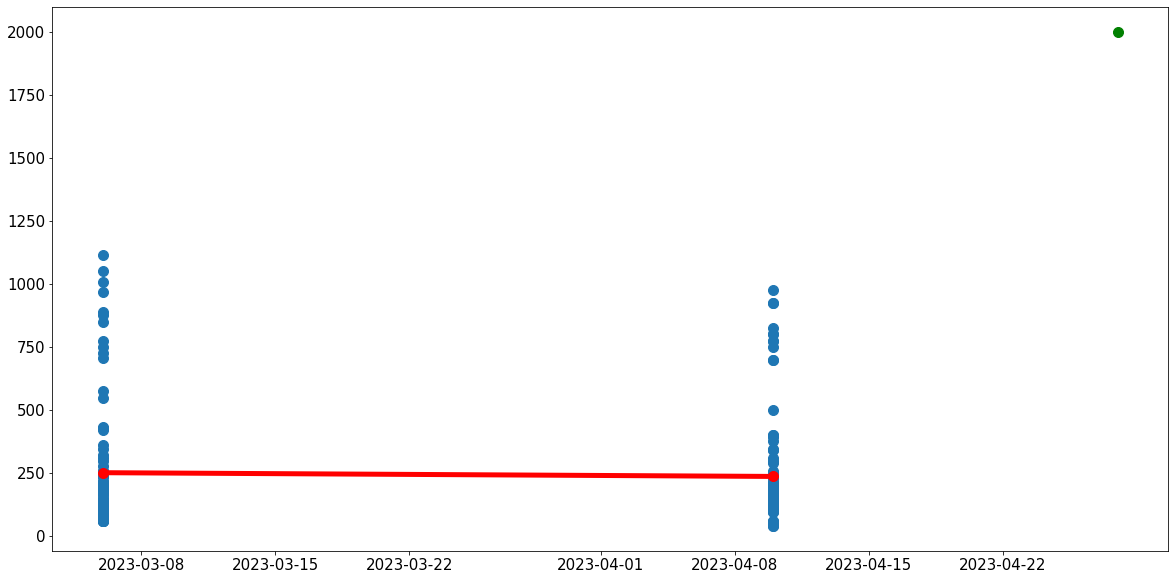

In [277]:
search_df_means = search_df[['price', 'end_date']].groupby("end_date").mean()

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(search_df['end_date'], search_df['price'], s=100)
ax.scatter(search_df_means.index, search_df_means['price'], color = "red", s = 100)
ax.plot(search_df_means.index, search_df_means['price'], color = "red", linewidth = 5)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.scatter(pd.to_datetime(datetime.today().strftime('%Y-%m-%d')), cur_price, s=100, color = "green");

In [360]:
search_df.reset_index(inplace=True)
search_df.rename(columns = {"Unnamed: 0": "Lot Number"}, 
          inplace = True)

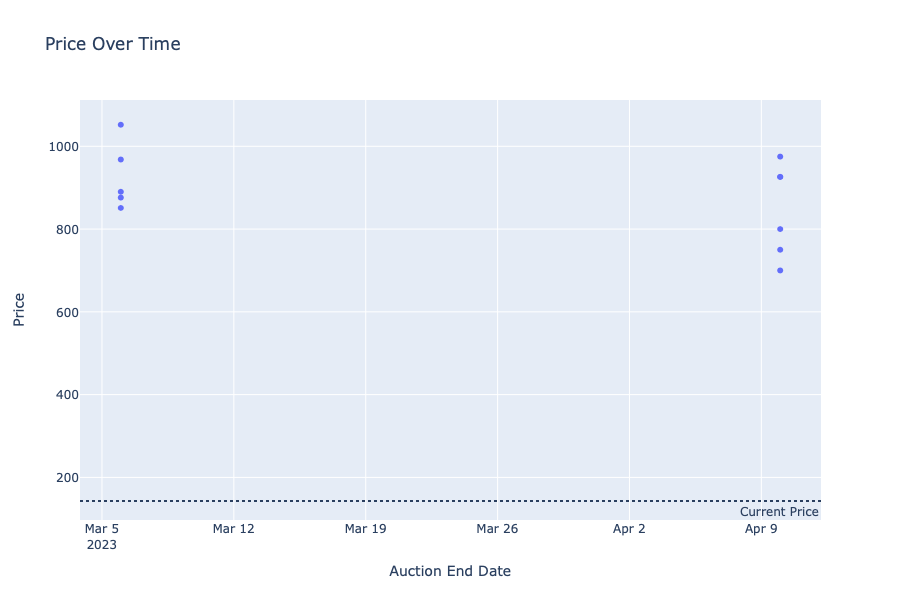

In [361]:
search_df_means = search_df[['price', 'end_date']].groupby("end_date").mean()


# fig, ax = plt.subplots(figsize=(20,10))
# ax.scatter(search_df['end_date'], search_df['price'], s=100)
# ax.scatter(search_df_means.index, search_df_means['price'], color = "red", s = 100)
# ax.plot(search_df_means.index, search_df_means['price'], color = "red", linewidth = 5)
# ax.tick_params(axis='both', which='major', labelsize=15)

# ax.scatter(pd.to_datetime(datetime.today().strftime('%Y-%m-%d')), cur_price, s=100, color = "green")

fig = px.scatter(search_df, search_df['end_date'], search_df['price'], hover_data = ['name', 'Lot Number'],
                labels={
                     "end_date": "Auction End Date",
                     "price": "Price"
                 },
                title="Price Over Time",
                width=900, height=600)
fig.add_hline(y=cur_price, line_dash="dot", annotation_text="Current Price", 
              annotation_position="bottom right")
fig.show()

In [ ]:
# expression = distillery (ex = Wild Turkey), age, proof, vintage (year), 
# uniquely identify each expression and track price over time
# only care about 